# Entrega Final de Algotrading - Antonio Fuziy

___

Importando as bibliotecas utilizadas 

In [21]:
!pip install pandas-ta
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
!pip install pandas-ta
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import random
import yahoofinancials as yf
import pandas_ta as ta
from scipy.stats import spearmanr
from statsmodels.tsa.stattools import coint
import statsmodels.tsa.stattools as st
import pandas.testing as tm
from statsmodels.tsa.stattools import adfuller
import scipy.optimize as sco

from backtesting_v2_2 import evaluateHist, evaluateIntr, Strategy, Order, TradingSystem, MarketData, Event

plt.style.use("dark_background")

In [24]:
tickers = ["KO", "PEP", "F", "GM", "BBD", "ITUB"]

In [25]:
start_date = '2017-03-06'
end_date =  '2022-03-06'

for ticker in tickers:
    data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, end_date, 'daily')
    raw = pd.DataFrame(data[ticker]['prices']).dropna()
    raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
    raw = raw.set_index('formatted_date')
    df = raw.iloc[:,1:]
    df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
    df.to_csv('{}.csv'.format(ticker))

In [26]:
df = pd.read_csv('{}.csv'.format(ticker))
df.head()

,formatted_date,open,high,low,close,adjclose,volume
0,2017-03-06,7.062380,7.078868,6.963451,6.996428,5.205885,10685014
1,2017-03-07,7.029404,7.034900,6.886507,6.908491,5.140450,11935920
2,2017-03-08,6.787579,6.859027,6.677659,6.754603,5.025948,14880053
3,2017-03-09,6.727123,6.776587,6.650179,6.710635,4.993232,17339835
4,2017-03-10,6.886507,6.886507,6.760099,6.815059,5.070930,14854398


In [98]:
class FuziyStrategy(Strategy):

    def __init__(self, ticker1, ticker2):
        self.period = 7
        
        self.sell_signals1 = []
        self.buy_signals1 = []
        self.sell_indexes1 = []
        self.buy_indexes1 = []
        
        self.sell_signals2 = []
        self.buy_signals2 = []
        self.sell_indexes2 = []
        self.buy_indexes2 = []

        self.prices1 = []
        self.price1 = 1
        self.prices2 = []
        self.price2 = 1

        self.multiple = 1
        
        self.coint_indicator = []
        self.pvalues = []
        self.coint_signal = 0
        
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        
        self.tam = 30
        
        self.side = 0
        self.signal = 0
        
        self.qty1 = 0
        self.qty2 = 0
        
        #====================================================================
        #CMO PARAMETERS
        #====================================================================
        self.cmo_indicator1 = []
        self.cmo_indicator2 = []
        self.cmo_signal1 = 0
        self.cmo_signal2 = 0
        
        self.init_capital = 100000
        self.avail_capital = self.init_capital
        
        self.combined_signals = 0
        
    def receive(self, event):
        
        orders = []
        
        if event.instrument == self.ticker1:
            self.prices1.append(event.price[3])
        elif event.instrument == self.ticker2:
            self.prices2.append(event.price[3])
        
        tam = min(len(self.prices1), len(self.prices2))
        if tam >= self.tam and len(self.prices1) == len(self.prices2):
            y = self.prices1[-self.tam:]
            x = self.prices2[-self.tam:]
            
            _, pvalue, _ = coint(x, y)
            self.pvalues.append(pvalue)

            model = st.OLS(y,x)
            results = model.fit()
            self.coint_indicator.append(results.resid[-1])
            
            self.coint_signal = self.side
            
            if self.coint_signal < 0 and results.resid[-1] < 0: 
                self.coint_signal = 0
            elif self.coint_signal > 0 and results.resid[-1] > 0: 
                self.coint_signal = 0
                
            elif pvalue < 1 and len(self.coint_indicator) > self.tam: 
                
                if results.resid[-1] < -2*np.std(self.coint_indicator[-self.tam:]):
                    self.coint_signal = 1
                elif results.resid[-1] > 2*np.std(self.coint_indicator[-self.tam:]):
                    self.coint_signal = -1

            if len(self.prices1) >= self.period + 1:
                close = pd.DataFrame({'close': self.prices1})
                cmo = close.ta.cmo(length=self.period)
                self.cmo_indicator1.append([cmo.iloc[-1]])

                cmo_value1 = cmo.iloc[-1]

                if cmo_value1 >= 50: 
                    self.cmo_signal1 = -1
                elif cmo_value1 <= -50:
                    self.cmo_signal1 = 1
                else:
                    self.cmo_signal1 = 0
            
            if len(self.prices2) >= self.period + 1:
                close = pd.DataFrame({'close': self.prices2})
                cmo = close.ta.cmo(length=self.period)
                self.cmo_indicator2.append([cmo.iloc[-1]])

                cmo_value2 = cmo.iloc[-1]

                if cmo_value2 >= 50: 
                    self.cmo_signal2 = -1
                elif cmo_value2 <= -50:
                    self.cmo_signal2 = 1
                else:
                    self.cmo_signal2 = 0

            self.combined_signals = self.cmo_signal1 + self.cmo_signal2 + self.coint_signal

            if self.combined_signals >= 2:
                self.signal = 1
            elif self.combined_signals <= -2:
                self.signal = -1
                    
            if self.side != self.signal:
                
                if self.qty1 > 0:
                    self.submit(self.id, Order(self.ticker1, Order.S, self.qty1, 0))
                elif self.qty1 < 0: 
                    self.submit(self.id, Order(self.ticker1, Order.B, self.qty1, 0))
                
                if self.qty2 > 0:
                    self.submit(self.id, Order(self.ticker2, Order.S, self.qty2, 0))
                elif self.qty2 < 0: 
                    self.submit(self.id, Order(self.ticker2, Order.B, self.qty2, 0))

                if self.price1 >= self.price2:
                    self.multiple = int(self.price1 / self.price2)
                    self.qty2 = 100 * self.signal * self.multiple
                    self.qty1 = -int(100 * self.signal)

                elif self.price1 < self.price2:
                    self.multiple = int(self.price2 / self.price1)
                    self.qty1 = 100 * self.signal
                    self.qty2 = -int(100 * self.signal) * self.multiple
               
                if self.qty1 > 0:
                    self.submit(self.id, Order(self.ticker1, Order.B, self.qty1, 0))
                    self.buy_signals1.append(self.prices1[-1])
                    self.buy_indexes1.append(len(self.prices1))
                elif self.qty1 < 0: 
                    self.submit(self.id, Order(self.ticker1, Order.SS, self.qty1, 0))
                    self.sell_signals1.append(self.prices1[-1])
                    self.sell_indexes1.append(len(self.prices1))
                
                if self.qty2 > 0:
                    self.submit(self.id, Order(self.ticker2, Order.B, self.qty2, 0))
                    self.buy_signals2.append(self.prices2[-1])
                    self.buy_indexes2.append(len(self.prices2))
                elif self.qty2 < 0: 
                    self.submit(self.id, Order(self.ticker2, Order.SS, self.qty2, 0))
                    self.sell_signals2.append(self.prices2[-1])
                    self.sell_indexes2.append(len(self.prices2))

                self.side = self.signal                
            
    def fill(self, id, instrument, price, quantity, status):
        if quantity != 0:
            print('Fill: {0} {1}@{2}'.format(instrument, quantity, price))

In [99]:
fuziy_strategy = FuziyStrategy('BBD', 'ITUB')

print(evaluateHist(fuziy_strategy, {'BBD': 'BBD.csv', 'ITUB': 'ITUB.csv'}))

Fill: BBD -100@5.159671783447266
Fill: ITUB 100@4.1828460693359375
Fill: BBD 100@5.860929012298584
Fill: ITUB -100@4.756077766418457
Fill: BBD 100@5.860929012298584
Fill: ITUB -100@4.756077766418457
Fill: BBD -100@7.0246052742004395
Fill: ITUB 100@5.5644378662109375
Fill: BBD -100@7.0246052742004395
Fill: ITUB 100@5.5644378662109375
Fill: BBD 100@6.985814571380615
Fill: ITUB -100@5.6330108642578125
Fill: BBD 100@6.985814571380615
Fill: ITUB -100@5.6330108642578125
Fill: BBD -100@6.1246185302734375
Fill: ITUB 100@5.903875827789307
Fill: BBD -100@6.1246185302734375
Fill: ITUB 100@5.903875827789307
Fill: BBD 100@5.1394877433776855
Fill: ITUB -100@5.080350875854492
Fill: BBD 100@5.1394877433776855
Fill: ITUB -100@5.080350875854492
Fill: BBD -100@4.623039722442627
Fill: ITUB 100@4.634009838104248
Fill: BBD -100@4.623039722442627
Fill: ITUB 100@4.634009838104248
Fill: BBD 100@5.943845272064209
Fill: ITUB -100@5.905468463897705
Fill: BBD 100@5.943845272064209
Fill: ITUB -100@5.905468463897705

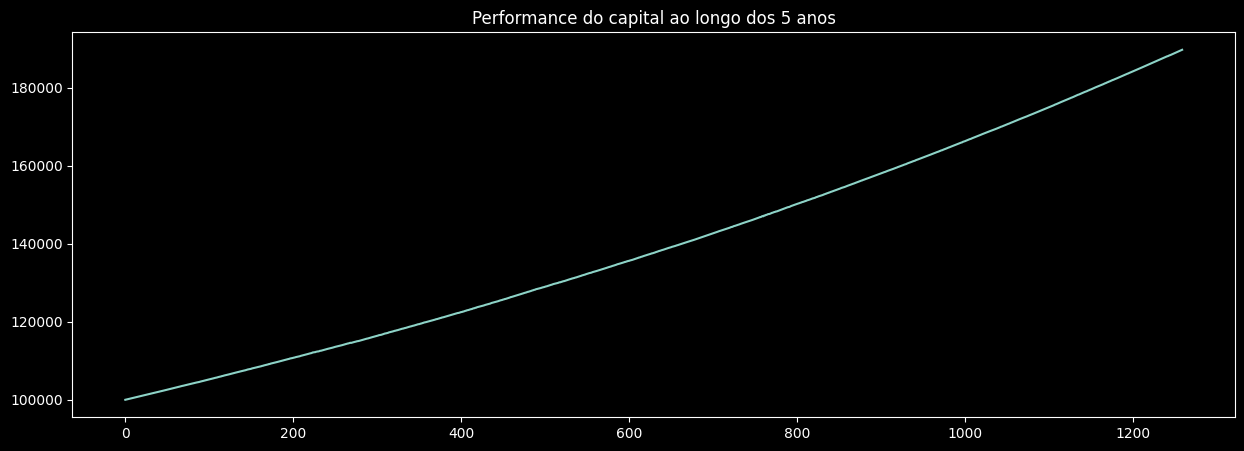

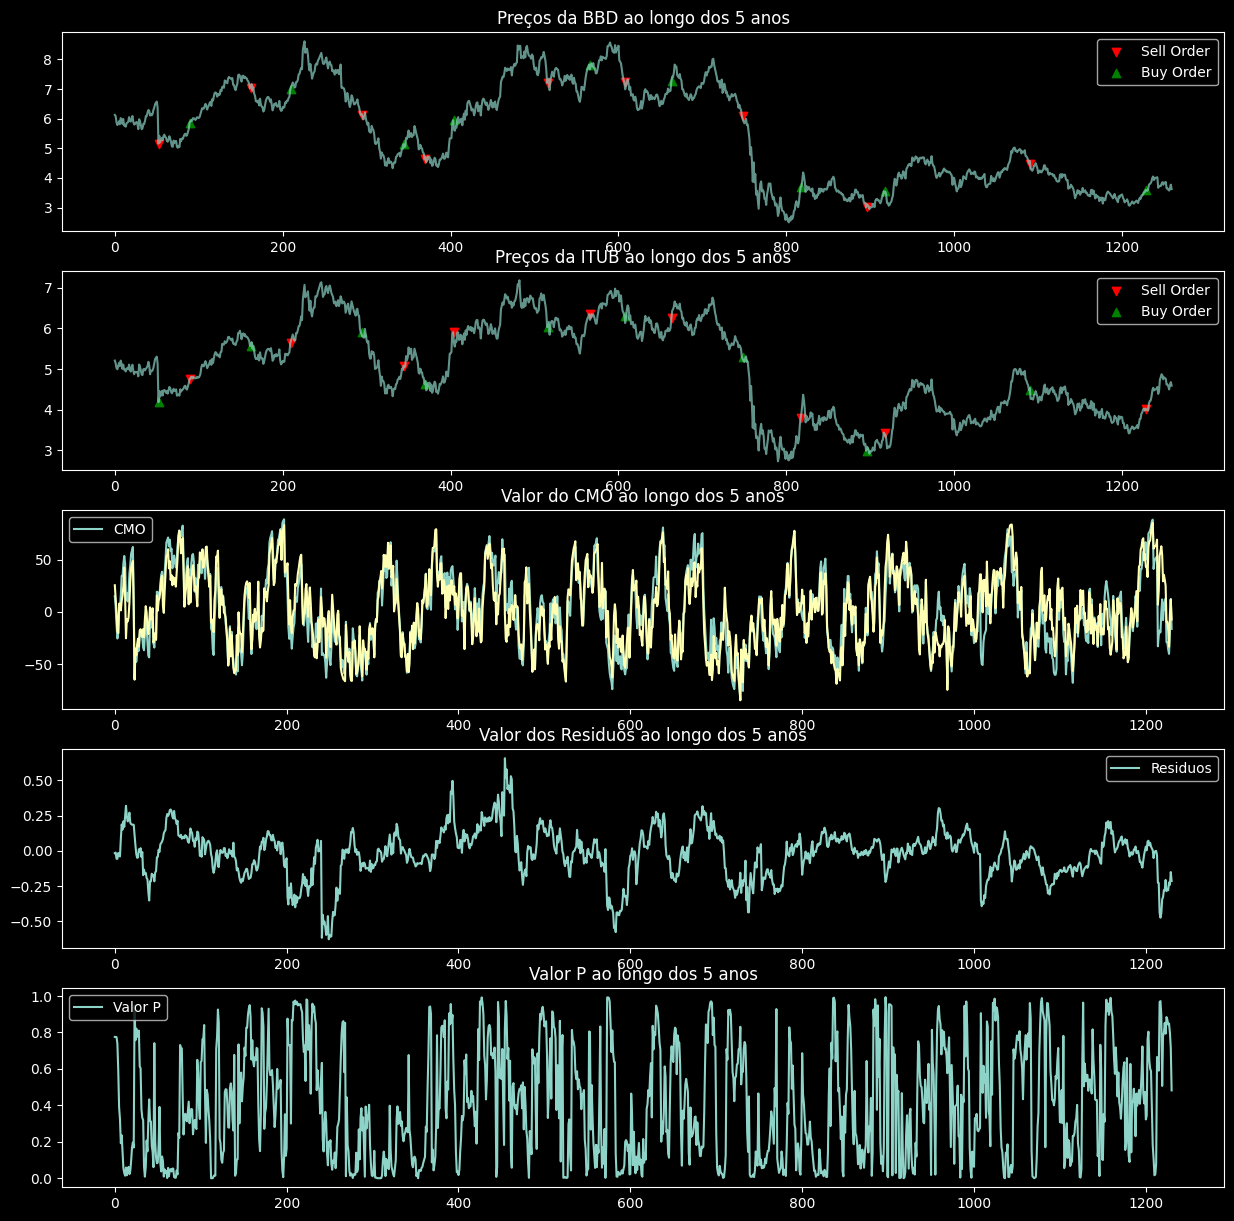

In [100]:
plt.figure(figsize=(15,5))
plt.plot([day[0] for day in fuziy_strategy._days.values()])
plt.title("Performance do capital ao longo dos 5 anos")
plt.show()

plt.figure(figsize=(15,15))

plt.subplot(5,1,1)
plt.plot(fuziy_strategy.prices1, alpha=0.7)
plt.scatter(fuziy_strategy.sell_indexes1, fuziy_strategy.sell_signals1, marker="v", color="red", label="Sell Order")
plt.scatter(fuziy_strategy.buy_indexes1, fuziy_strategy.buy_signals1, marker="^", color="green", label="Buy Order")
plt.legend()
plt.title("Preços da BBD ao longo dos 5 anos")

plt.subplot(5,1,2)
plt.plot(fuziy_strategy.prices2, alpha=0.7)
plt.scatter(fuziy_strategy.sell_indexes2, fuziy_strategy.sell_signals2, marker="v", color="red", label="Sell Order")
plt.scatter(fuziy_strategy.buy_indexes2, fuziy_strategy.buy_signals2, marker="^", color="green", label="Buy Order")
plt.legend()
plt.title("Preços da ITUB ao longo dos 5 anos")

plt.subplot(5,1,3)
plt.plot(fuziy_strategy.cmo_indicator1)
plt.plot(fuziy_strategy.cmo_indicator2)
plt.legend(['CMO']);
plt.title("Valor do CMO ao longo dos 5 anos")

plt.subplot(5,1,4)
plt.plot(fuziy_strategy.coint_indicator)
plt.legend(['Residuos']);
plt.title("Valor dos Residuos ao longo dos 5 anos")

plt.subplot(5,1,5)
plt.plot(fuziy_strategy.pvalues)
plt.legend(['Valor P']);
plt.title("Valor P ao longo dos 5 anos")

plt.show()

In [101]:
fuziy_strategy = FuziyStrategy('F', 'GM')

print(evaluateHist(fuziy_strategy, {'F': 'F.csv', 'GM': 'GM.csv'}))

Fill: F -100@8.081021308898926
Fill: GM 100@28.373641967773438
Fill: F 100@8.884617805480957
Fill: GM -100@32.27437210083008
Fill: F 100@8.884617805480957
Fill: GM -100@32.27437210083008
Fill: F -100@8.451043128967285
Fill: GM 100@36.98640441894531
Fill: F -100@8.451043128967285
Fill: GM 100@36.98640441894531
Fill: F 100@7.810667514801025
Fill: GM -100@37.04177474975586
Fill: F 100@7.810667514801025
Fill: GM -100@37.04177474975586
Fill: F -100@7.794600009918213
Fill: GM 100@35.64634704589844
Fill: F -100@7.794600009918213
Fill: GM 100@35.64634704589844
Fill: F 100@8.397870063781738
Fill: GM -100@36.507816314697266
Fill: F 100@8.397870063781738
Fill: GM -100@36.507816314697266
Fill: F -100@6.472662448883057
Fill: GM 100@31.067358016967773
Fill: F -100@6.472662448883057
Fill: GM 100@31.067358016967773
Fill: F 100@5.881797790527344
Fill: GM -100@28.881118774414062
Fill: F 100@5.881797790527344
Fill: GM -100@28.881118774414062
Fill: F -100@11.88892936706543
Fill: GM 100@53.661834716796875


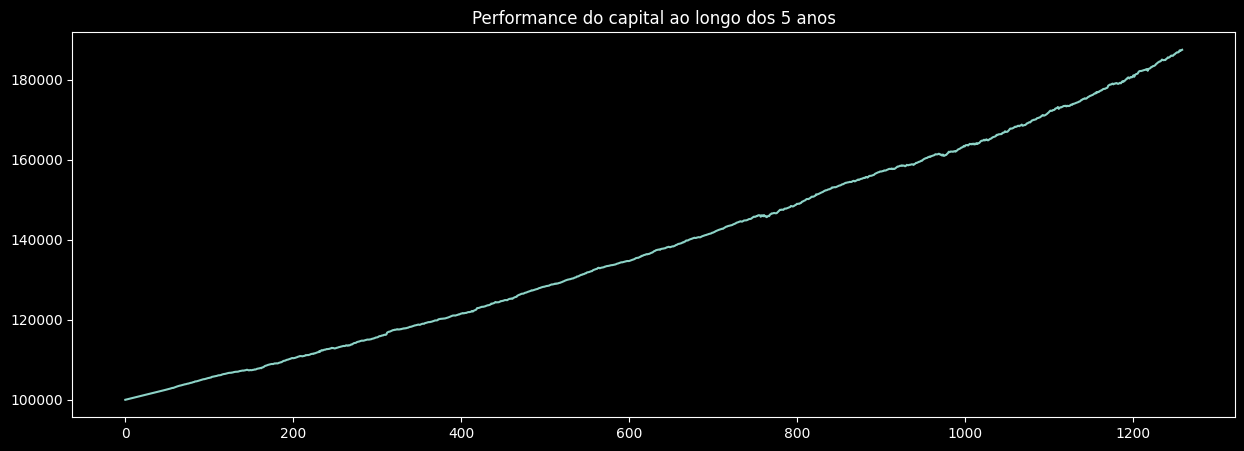

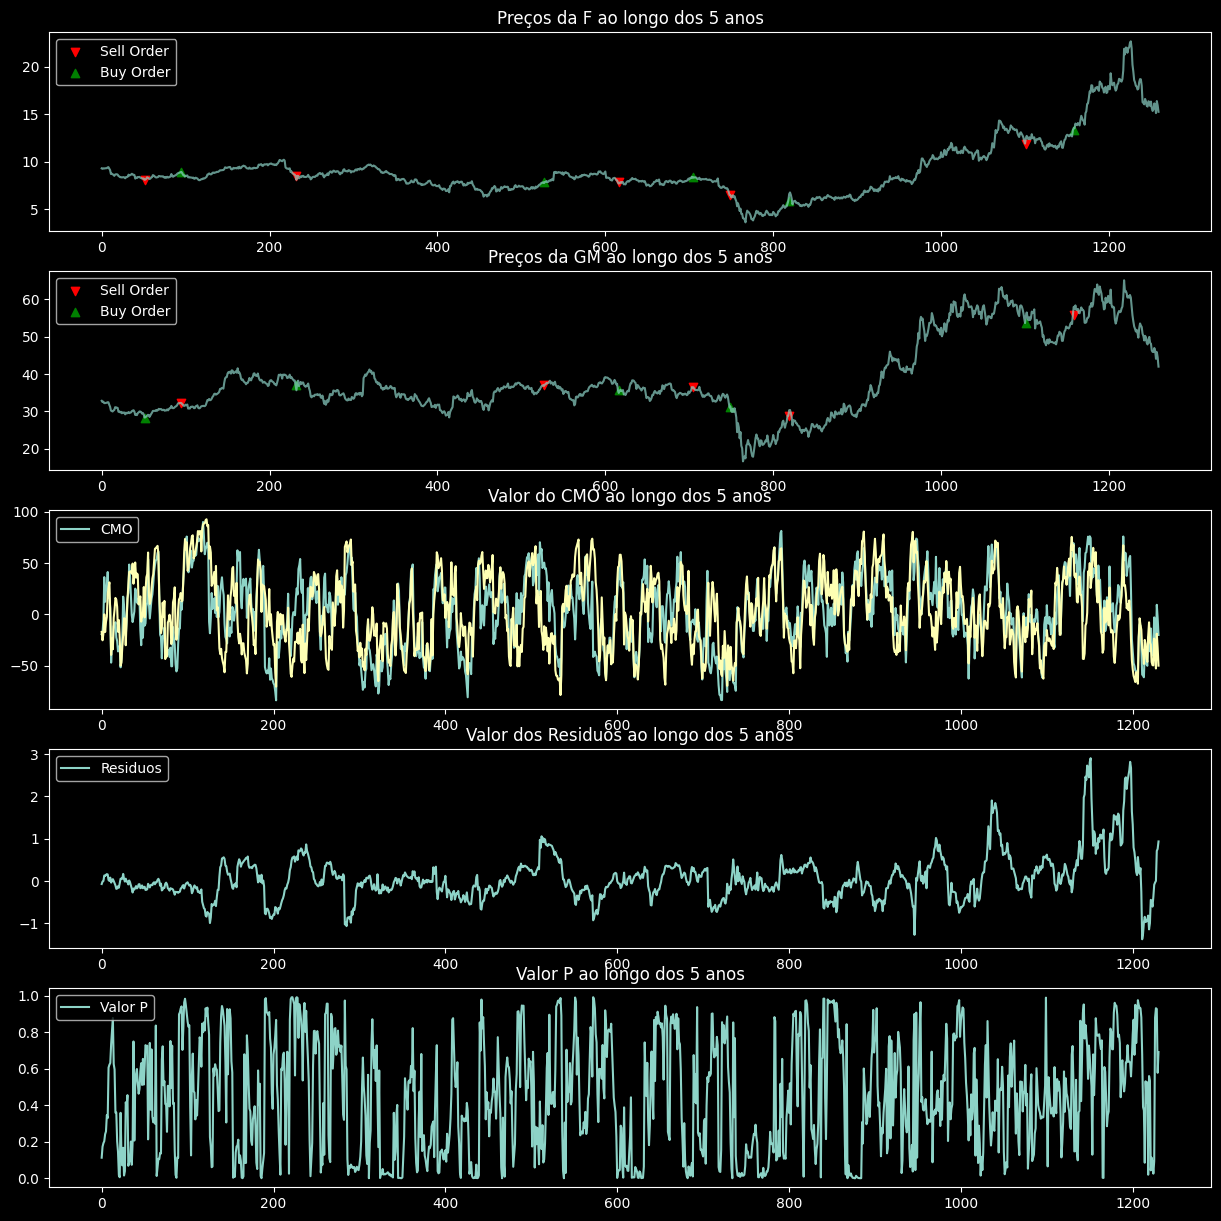

In [102]:
plt.figure(figsize=(15,5))
plt.plot([day[0] for day in fuziy_strategy._days.values()])
plt.title("Performance do capital ao longo dos 5 anos")
plt.show()

plt.figure(figsize=(15,15))

plt.subplot(5,1,1)
plt.plot(fuziy_strategy.prices1, alpha=0.7)
plt.scatter(fuziy_strategy.sell_indexes1, fuziy_strategy.sell_signals1, marker="v", color="red", label="Sell Order")
plt.scatter(fuziy_strategy.buy_indexes1, fuziy_strategy.buy_signals1, marker="^", color="green", label="Buy Order")
plt.legend()
plt.title("Preços da F ao longo dos 5 anos")

plt.subplot(5,1,2)
plt.plot(fuziy_strategy.prices2, alpha=0.7)
plt.scatter(fuziy_strategy.sell_indexes2, fuziy_strategy.sell_signals2, marker="v", color="red", label="Sell Order")
plt.scatter(fuziy_strategy.buy_indexes2, fuziy_strategy.buy_signals2, marker="^", color="green", label="Buy Order")
plt.legend()
plt.title("Preços da GM ao longo dos 5 anos")

plt.subplot(5,1,3)
plt.plot(fuziy_strategy.cmo_indicator1)
plt.plot(fuziy_strategy.cmo_indicator2)
plt.legend(['CMO']);
plt.title("Valor do CMO ao longo dos 5 anos")

plt.subplot(5,1,4)
plt.plot(fuziy_strategy.coint_indicator)
plt.legend(['Residuos']);
plt.title("Valor dos Residuos ao longo dos 5 anos")

plt.subplot(5,1,5)
plt.plot(fuziy_strategy.pvalues)
plt.legend(['Valor P']);
plt.title("Valor P ao longo dos 5 anos")

plt.show()